<a href="https://colab.research.google.com/github/ChristalL99/Reinforce_Research-/blob/main/LunarLander_20210327.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
! pip install box2d-py

# LunarLander - Original (REINFORCE)

Reinforce.py

In [44]:
import argparse
import gym
import numpy as np
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical


parser = argparse.ArgumentParser(description='PyTorch REINFORCE example')
parser.add_argument('--gamma', type=float, default=0.99, metavar='G',
                    help='discount factor (default: 0.99)')
parser.add_argument('--seed', type=int, default=543, metavar='N',
                    help='random seed (default: 543)')
parser.add_argument('--render', action='store_true',
                    help='render the environment')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='interval between training status logs (default: 10)')
# args = parser.parse_args()
args, unknown = parser.parse_known_args()


# env = gym.make('CartPole-v0')
env = gym.make("LunarLander-v2")
env.seed(args.seed)
torch.manual_seed(args.seed)


class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(8, 128)
        #self.affine2 = nn.Linear(128, 128)
        self.affine3 = nn.Linear(128, 2)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        #x = F.relu(self.affine2(x))

        action_scores = self.affine3(x)
        return F.softmax(action_scores, dim=1)


policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()


def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    return action.item()


def finish_episode():
    R = 0
    policy_loss = []
    rewards = []
    for r in policy.rewards[::-1]:
        R = r + args.gamma * R
        rewards.insert(0, R)
    rewards = torch.tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + eps)

    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]


# def main():
running_reward = 10
res = []
for i_episode in count(1):
    state = env.reset()
    for t in range(10000):  # Don't infinite loop while learning
        action = select_action(state)
        state, reward, done, _ = env.step(action)
        if args.render:
            env.render()
        policy.rewards.append(reward)
        if done:
            break

    running_reward = running_reward * 0.99 + t * 0.01
    finish_episode()


    if i_episode > 10000:
        break

    if i_episode % args.log_interval == 0:
        print('Episode {}\tLast length: {:5d}\tAverage length: {:.2f}'.format(
                i_episode, t, running_reward))
        res.append(running_reward)

    '''
    if running_reward > env.spec.reward_threshold:
        print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
        break
    '''

# import matplotlib.pyplot as plt
# plt.title("Original reinforce.")
# plt.plot(res)
# plt.savefig('ori.png')
# plt.show()


# if __name__ == '__main__':
#     main()


Episode 10	Last length:    79	Average length: 15.69
Episode 20	Last length:    75	Average length: 20.73
Episode 30	Last length:    58	Average length: 25.65
Episode 40	Last length:    64	Average length: 30.00
Episode 50	Last length:    59	Average length: 33.46
Episode 60	Last length:    55	Average length: 36.69
Episode 70	Last length:    53	Average length: 39.48
Episode 80	Last length:    74	Average length: 42.29
Episode 90	Last length:    63	Average length: 44.96
Episode 100	Last length:    59	Average length: 47.10
Episode 110	Last length:    92	Average length: 49.95
Episode 120	Last length:    73	Average length: 51.05
Episode 130	Last length:    83	Average length: 52.74
Episode 140	Last length:   101	Average length: 54.21
Episode 150	Last length:    74	Average length: 55.11
Episode 160	Last length:    65	Average length: 56.26
Episode 170	Last length:    65	Average length: 57.56
Episode 180	Last length:    87	Average length: 58.62
Episode 190	Last length:    54	Average length: 59.79
Ep

# LunarLander - EDF (REINFORCE_RP)

function.py

In [33]:
# -*- coding: utf-8 -*-


import torch
from torch.autograd import Function
from numpy import prod


class HookFunction(Function):
    @staticmethod
    def forward(ctx, input, labels, fixed_fb_weights, train_mode, learningrate):
        if train_mode in ["DRTP"]:
            ctx.save_for_backward(input, labels, fixed_fb_weights)
        ctx.in1 = train_mode
        ctx.in2 = learningrate
        return input

    @staticmethod
    def backward(ctx, grad_output):
        train_mode = ctx.in1
        learningrate = ctx.in2
        if train_mode == "BP":
            return grad_output, None, None, None, None

        input, labels, fixed_fb_weights = ctx.saved_variables  # 提取前向传播中缓存的变量

        if train_mode == "DRTP":
            grad_output_est = labels.mm(fixed_fb_weights.view(-1, prod(fixed_fb_weights.shape[1:]))).view(
                grad_output.shape)
        else:
            raise NameError("=== ERROR: training mode " + str(train_mode) + " not supported")

        grad_output_est = grad_output_est * learningrate
        return grad_output_est, None, None, None, None

trainingHook = HookFunction.apply


models.py

In [34]:
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
# import function
# from module import TrainingHook


class NetworkBuilder(nn.Module):

    def __init__(self, input_size, label_features):
        super(NetworkBuilder, self).__init__()

        self.layers = nn.ModuleList()
        num_layers = 2
        topology_layers = [['FC','128'],['FC',str(label_features)]]

        self.saved_log_probs = []
        self.rewards = []
        self.labels = []


        for i in range(num_layers):  # topology_layers [['CONV', '32', '5', '1', '2'], ['FC', '1000'], ['FC', '10']]
            layer = topology_layers[i] #遍历各个层
            try:
                if layer[0] == "FC":
                    if (i == 0):
                        # input_dim = pow(input_size,2)*input_channels
                        input_dim = input_size

                    elif topology_layers[i - 1][0] == "FC":

                        input_dim = output_dim
                        # print('else')

                    output_dim = int(layer[1])
                    output_layer = (i == (num_layers - 1)) #是否为输出层
                    self.layers.append(FC_block(
                        in_features=input_dim,
                        out_features=output_dim,
                        bias=True,
                        activation='softmax' if output_layer else 'none',  # thomas
                        dim_hook=None if output_layer else [label_features, output_dim],  #输出层使用BP 不使用hook
                        label_features=label_features,
                        train_mode=("BP" if output_layer else "DRTP"),
                    ))

                else:
                    raise NameError("=== ERROR: layer construct not supported")
            except ValueError as e:
                raise ValueError("=== ERROR: unsupported layer parameter format: " + str(e))

    def forward(self, input,id, lr):
        x = input.float()

        for i in range(len(self.layers)): #遍历每一层 空间维度
            x = self.layers[i](x,  self.labels[id], lr) #DRTP/RP 可以不传y或y为none  y在这里代表模型输出，占位用的初始化为0， 一旦前传结束 y将被赋值为模型输出  然后用于反向传播中 error或error sign的计算

        return x



class FC_block(nn.Module):
    def __init__(self, in_features, out_features, bias, activation, dim_hook, label_features,train_mode):
        super(FC_block, self).__init__()
        self.in_features = in_features #输入维度
        self.out_features = out_features #输出维度

        self.fc = nn.Linear(in_features=in_features, out_features=out_features, bias=bias) #线性变换层

        self.act = Activation(activation) # 激活函数

        self.hook = TrainingHook(label_features=label_features, dim_hook=dim_hook, train_mode=train_mode) # label_features target维度， dim_hook 随机矩阵B的维度


    def forward(self, x, labels,lr):

        x = self.fc(x)
        x = self.act(x)
        x = self.hook(x, labels, lr)  #SNN的反向传播 需要考虑每个时间步 类似于RNN  不过如果使用TP 各个时间步好像是独立的，每个时间步都是一个独立的前馈网络

        return x




class Activation(nn.Module):
    def __init__(self, activation):
        super(Activation, self).__init__()

        if activation == "tanh":
            self.act = nn.Tanh()
        elif activation == "sigmoid":
            self.act = nn.Sigmoid()
        elif activation == "relu":
            self.act = nn.ReLU()
        elif activation == "softmax":
            self.act = nn.Softmax()
        elif activation == "none":
            self.act = None
        else:
            raise NameError("=== ERROR: activation " + str(activation) + " not supported")

    def forward(self, x):
        if self.act == None:
            return x
        else:
            return self.act(x)


module.py

In [35]:
# -*- coding: utf-8 -*-


import torch
import torch.nn as nn
# from function import trainingHook



class TrainingHook(nn.Module):
    def __init__(self, label_features, dim_hook, train_mode):
        super(TrainingHook, self).__init__()
        self.train_mode = train_mode  # 更新模式

        if self.train_mode in ["DRTP"]:
            # 随机初始化 tensor B 并固定
            self.fixed_fb_weights = nn.Parameter(torch.Tensor(torch.Size(
                dim_hook)))  # Conv：dim_hook=[label_features, out_channels, output_dim, output_dim]；FC：dim_hook = [label_features, output_dim]
            self.reset_weights()
        else:
            self.fixed_fb_weights = None

    def reset_weights(self):
        torch.nn.init.uniform_(self.fixed_fb_weights,-1,1)
        #torch.nn.init.kaiming_uniform_(self.fixed_fb_weights)
        self.fixed_fb_weights.requires_grad = False  # 固定

    def forward(self, input, labels, learningrate):
        return trainingHook(input, labels, self.fixed_fb_weights, self.train_mode, learningrate)

    def __repr__(self):
        return self.__class__.__name__ + ' (' + self.train_mode + ')'


Reinforce_RP.py

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


Episode 10	Current_reward:-397.46 	Average reward: -302.15
Episode 20	Current_reward:-304.06 	Average reward: -282.26
Episode 30	Current_reward:-102.05 	Average reward: -251.88
Episode 40	Current_reward:-188.67 	Average reward: -234.88
Episode 50	Current_reward:-131.41 	Average reward: -215.88
Episode 60	Current_reward:-168.61 	Average reward: -219.27
Episode 70	Current_reward:-188.56 	Average reward: -213.52
Episode 80	Current_reward:-396.46 	Average reward: -221.15
Episode 90	Current_reward:-310.54 	Average reward: -214.76
Episode 100	Current_reward:-17.90 	Average reward: -209.41
Episode 110	Current_reward:-75.34 	Average reward: -188.20
Episode 120	Current_reward:-71.17 	Average reward: -170.93
Episode 130	Current_reward:-43.82 	Average reward: -162.67
Episode 140	Current_reward:-136.54 	Average reward: -158.77
Episode 150	Current_reward:-94.30 	Average reward: -156.84
Episode 160	Current_reward:-132.75 	Average reward: -144.14
Episode 170	Current_reward:-124.03 	Average reward: -1

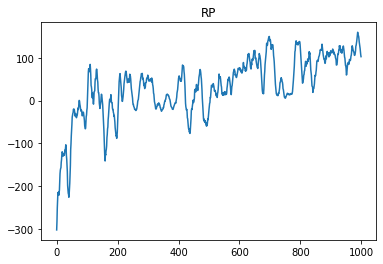

In [42]:
import argparse
import gym
import numpy as np
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# import models

parser = argparse.ArgumentParser(description='PyTorch REINFORCE example')
parser.add_argument('--gamma', type=float, default=0.99, metavar='G',
                    help='discount factor (default: 0.99)')
parser.add_argument('--seed', type=int, default=543, metavar='N',
                    help='random seed (default: 543)')
parser.add_argument('--render', action='store_true',
                    help='render the environment')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='interval between training status logs (default: 10)')
# args = parser.parse_args()
args, unknown = parser.parse_known_args()


# env = gym.make('CartPole-v0')
env = gym.make('LunarLander-v2')

env.seed(args.seed)
torch.manual_seed(args.seed)


policy = NetworkBuilder(env.observation_space.shape[0],env.action_space.n)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()


def select_action(state,id, learningrate):
    state = torch.from_numpy(state).float().unsqueeze(0)
    label = torch.zeros(1,env.action_space.n)
    policy.labels.append(label)
    probs = policy(state,id, learningrate)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    return action.item()


def finish_episode(actions):
    R = 0
    policy_loss = []
    rewards = []
    for r in policy.rewards[::-1]:
        R = r + args.gamma * R
        rewards.insert(0, R)
    rewards = torch.tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + eps)

    label = torch.tensor(actions)
    targets = torch.zeros(len(actions), env.action_space.n).scatter_(1, label.unsqueeze(1).long(), 1.0)

    i = 0
    for log_prob, reward ,target in zip(policy.saved_log_probs, rewards,targets):
        #policy.labels[i] = target.reshape(1,2) * reward
        
        # target = target.reshape(1,2) * (1-torch.sigmoid(torch.FloatTensor([reward])))
        target = target.reshape(1,env.action_space.n) * reward
        #target = target.reshape(1,2)
        policy.labels[i].data.copy_(target.data)
        #policy.labels[i] = target.reshape(1,2) * reward

        policy_loss.append(-log_prob * reward)
        i = i + 1



    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]
    del policy.labels[:]


# def main():
running_reward = 10
average_reward = []
res2 = []
for i_episode in count(1):
    state = env.reset()
    actions = []
    id = 0
    # lr = torch.exp(torch.FloatTensor([-t]))
    lr = torch.exp(torch.FloatTensor([-i_episode/10])) ## adjust learning rate here
    for t in range(1000):  # Don't infinite loop while learning
        action = select_action(state,id, lr)
        id += 1
        actions.append(action)
        state, reward, done, _ = env.step(action)
        if args.render:
            env.render()
        policy.rewards.append(reward)
        if done:
            break

    running_reward = running_reward * 0.99 + t * 0.01
    average_reward.append(np.sum(policy.rewards))
    finish_episode(actions)

    if i_episode>10000:
        break
        
        
    if i_episode % args.log_interval == 0:
        print('Episode {}\tCurrent_reward:{:.2f} \tAverage reward: {:.2f}'.format(
            i_episode, average_reward[-1], np.mean(average_reward[-100:])))

        res2.append(np.mean(average_reward[-100:]))
        
        # if running_reward > env.spec.reward_threshold:
        #     print("Solved! Running reward is now {} and "
        #           "the last episode runs to {} time steps!".format(running_reward, t))
        #     break
        
import matplotlib.pyplot as plt
plt.title("RP")
plt.plot(res2)
plt.savefig('RP.png')
plt.show()


# if __name__ == '__main__':
#     main()


# Plot

Text(0, 0.5, 'Smooth Rewards')

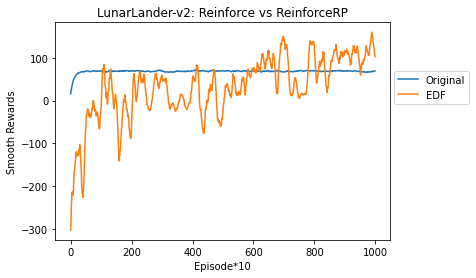

In [45]:
plt.plot(res,label="Original")
plt.plot(res2,label="EDF")

plt.title("LunarLander-v2: Reinforce vs ReinforceRP")
plt.legend(bbox_to_anchor=(1.25,0.8))
plt.xlabel("Episode*10")
plt.ylabel("Smooth Rewards")